In [1]:
import numpy as np
import xarray as xr
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
from src.score import *
import re

import generate_data as gd

In [2]:
# resnet/whole_mm_indiv_data.py using 5 blocks

In [3]:
DATADIR = '/rds/general/user/mc4117/home/WeatherBench/data/'

z500_valid = load_test_data(f'{DATADIR}geopotential_500', 'z')
t850_valid = load_test_data(f'{DATADIR}temperature_850', 't')
valid = xr.merge([z500_valid, t850_valid])


In [5]:
# For the data generator all variables have to be merged into a single dataset.
var_dict = {
    'geopotential': ('z', [500]),
    'temperature': ('t', [850])
}

# For the data generator all variables have to be merged into a single dataset.
ds = [xr.open_mfdataset(f'{DATADIR}/{var}/*.nc', combine='by_coords') for var in var_dict.keys()]
ds_whole = xr.merge(ds, compat = 'override')

# load all training data
ds_train = ds_whole.sel(time=slice('1979', '2016'))
ds_test = ds_whole.sel(time=slice('2017', '2018'))

class DataGenerator(keras.utils.Sequence):
    def __init__(self, ds, var_dict, lead_time, batch_size=32, shuffle=True, load=True,
                 mean=None, std=None, output_vars=None):
        """
        Data generator for WeatherBench data.
        Template from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
        Args:
            ds: Dataset containing all variables
            var_dict: Dictionary of the form {'var': level}. Use None for level if data is of single level
            lead_time: Lead time in hours
            batch_size: Batch size
            shuffle: bool. If True, data is shuffled.
            load: bool. If True, datadet is loaded into RAM.
            mean: If None, compute mean from data.
            std: If None, compute standard deviation from data.
        """

        self.ds = ds
        self.var_dict = var_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.lead_time = lead_time

        data = []
        level_names = []
        generic_level = xr.DataArray([1], coords={'level': [1]}, dims=['level'])
        for long_var, params in var_dict.items():
            if long_var == 'constants':
                for var in params:
                    data.append(ds[var].expand_dims(
                        {'level': generic_level, 'time': ds.time}, (1, 0)
                    ))
                    level_names.append(var)
            else:
                var, levels = params
                try:
                    data.append(ds[var].sel(level=levels))
                    level_names += [f'{var}_{level}' for level in levels]
                except ValueError:
                    data.append(ds[var].expand_dims({'level': generic_level}, 1))
                    level_names.append(var)

        self.data = xr.concat(data, 'level').transpose('time', 'lat', 'lon', 'level')
        self.data['level_names'] = xr.DataArray(
            level_names, dims=['level'], coords={'level': self.data.level})
        if output_vars is None:
            self.output_idxs = range(len(dg_valid.data.level))
        else:
            self.output_idxs = [i for i, l in enumerate(self.data.level_names.values)
                                if any([bool(re.match(o, l)) for o in output_vars])]

        # Normalize
        self.mean = self.data.mean(('time', 'lat', 'lon')).compute() if mean is None else mean
#         self.std = self.data.std('time').mean(('lat', 'lon')).compute() if std is None else std
        self.std = self.data.std(('time', 'lat', 'lon')).compute() if std is None else std
        self.data = (self.data - self.mean) / self.std

        self.n_samples = self.data.isel(time=slice(0, -lead_time)).shape[0]
        self.init_time = self.data.isel(time=slice(None, -lead_time)).time
        self.valid_time = self.data.isel(time=slice(lead_time, None)).time

        self.on_epoch_end()

        # For some weird reason calling .load() earlier messes up the mean and std computations
        if load: print('Loading data into RAM'); self.data.load()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(self.n_samples / self.batch_size))

    def __getitem__(self, i):
        'Generate one batch of data'
        idxs = self.idxs[i * self.batch_size:(i + 1) * self.batch_size]
        X = self.data.isel(time=idxs).values
        y = self.data.isel(time=idxs + self.lead_time, level=self.output_idxs).values
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.idxs = np.arange(self.n_samples)
        if self.shuffle == True:
            np.random.shuffle(self.idxs)        
            
import re

bs=32
lead_time=72
output_vars = ['z_500', 't_850']

txt = open('dg_train.txt').read()
output = [i.split(': ') for i in txt.split('\n')]

output_mean = [float(output[0][1]), float(output[1][1])]
output_std = [float(output[2][1]), float(output[3][1])]

# Now also a generator for testing. Impartant: Shuffle must be False!
dg_test = DataGenerator(ds_test, var_dict, lead_time, batch_size=bs, mean=output_mean, std=output_std,
                         shuffle=False, output_vars=output_vars)

Loading data into RAM


In [6]:
pred_ensemble_1 = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/whole_res_indiv_data_do_5_specific_humidity.npy')
pred_ensemble_1a = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/whole_res_indiv_data2_do_5_specific_humidity.npy')
pred_ensemble_2 = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/whole_res_indiv_data_do_5_2m temp.npy')
pred_ensemble_3 = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/whole_res_indiv_data_do_5_solar rad.npy')
pred_ensemble_3a = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/whole_res_indiv_data2_do_5_solar rad.npy')
pred_ensemble_4 = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/whole_res_indiv_data_do_5_pot_vort.npy')
pred_ensemble_4a = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/whole_res_indiv_data2_do_5_pot_vort.npy')
pred_ensemble_5 = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/whole_res_indiv_data_do_5_const.npy')
pred_ensemble_5a = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/whole_res_indiv_data2_do_5_const.npy')
pred_ensemble_6 = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/whole_res_indiv_data_do_5_orig.npy')

In [17]:
pred_ensemble_6 = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/whole_res_indiv_data_do_5_orig.npy')

In [40]:
samples = 20
preds_sh = xr.Dataset({
    'z': xr.DataArray(
        pred_ensemble_1[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    ),
    't': xr.DataArray(
        pred_ensemble_1[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    )
})

preds_sha = xr.Dataset({
    't': xr.DataArray(
        pred_ensemble_1a[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': 20+np.arange(samples), 
                },
    ),
    'z': xr.DataArray(
        pred_ensemble_1a[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': 20+np.arange(samples), 
                },
    )
})

preds_2mtemp = xr.Dataset({
    'z': xr.DataArray(
        pred_ensemble_2[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': 40+ np.arange(samples), 
                },
    ),
    't': xr.DataArray(
        pred_ensemble_2[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': 40+ np.arange(samples), 
                },
    )
})


preds_pv = xr.Dataset({
    'z': xr.DataArray(
        pred_ensemble_4[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': 60+ np.arange(samples), 
                },
    ),
    't': xr.DataArray(
        pred_ensemble_4[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': 60 + np.arange(samples), 
                },
    )
})

preds_pva = xr.Dataset({
    't': xr.DataArray(
        pred_ensemble_4a[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': 80+ np.arange(samples), 
                },
    ),
    'z': xr.DataArray(
        pred_ensemble_4a[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': 80 + np.arange(samples), 
                },
    )
})

preds_const = xr.Dataset({
    't': xr.DataArray(
        pred_ensemble_5[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': 100+ np.arange(samples), 
                },
    ),
    'z': xr.DataArray(
        pred_ensemble_5[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': 100 + np.arange(samples), 
                },
    )
})

preds_consta = xr.Dataset({
    't': xr.DataArray(
        pred_ensemble_5a[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': 120+ np.arange(samples), 
                },
    ),
    'z': xr.DataArray(
        pred_ensemble_5a[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': 120 + np.arange(samples), 
                },
    )
})


preds_orig = xr.Dataset({
    'z': xr.DataArray(
        pred_ensemble_6[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': 140+ np.arange(20), 
                },
    ),
    't': xr.DataArray(
        pred_ensemble_6[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': 140 + np.arange(20), 
                },
    )
})


preds_sr = xr.Dataset({
    'z': xr.DataArray(
        pred_ensemble_3[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': 160 + np.arange(samples), 
                },
    ),
    't': xr.DataArray(
        pred_ensemble_3[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': 160 + np.arange(samples), 
                },
    )
})

preds_sra = xr.Dataset({
    'z': xr.DataArray(
        pred_ensemble_3a[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': 180 + np.arange(samples), 
                },
    ),
    't': xr.DataArray(
        pred_ensemble_3a[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': 180 + np.arange(samples), 
                },
    )
})


In [8]:
X1, y1 = dg_test[0]

for i in range(1, len(dg_test)):
    X2, y2 = dg_test[i]
    y1 = np.concatenate((y1, y2))  

In [10]:
real_unnorm =y1* output_std + output_mean

real_ds = xr.Dataset({
    'z': xr.DataArray(
        real_unnorm[..., 0],
        dims=['time', 'lat', 'lon'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                },
    ),
    't': xr.DataArray(
        real_unnorm[..., 1],
        dims=['time', 'lat', 'lon'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                },
    )
})

In [19]:
ens_rmse_list_1 = []

ens_1 = preds_sh.isel(ens = 0).copy()

ens_rmse_list_1.append(compute_weighted_rmse(ens_1, real_ds).compute())

for i in range(1, len(preds_sh.ens)):
    ens_1 += preds_sh.isel(ens = i).copy()
    ens_rmse_list_1.append(compute_weighted_rmse(ens_1/(i+1), real_ds).compute())

ens_rmse_list_1a = []

ens_1a = preds_sha.isel(ens = 0).copy()

ens_rmse_list_1a.append(compute_weighted_rmse(ens_1a, real_ds).compute())

for i in range(1, len(preds_sha.ens)):
    ens_1a += preds_sha.isel(ens = i).copy()
    ens_rmse_list_1a.append(compute_weighted_rmse(ens_1a/(i+1), real_ds).compute())    

ens_rmse_list_2 = []

ens_2 = preds_2mtemp.isel(ens = 0).copy()

ens_rmse_list_2.append(compute_weighted_rmse(ens_2, real_ds).compute())

for i in range(1, len(preds_2mtemp.ens)):
    ens_2 += preds_2mtemp.isel(ens = i).copy()
    ens_rmse_list_2.append(compute_weighted_rmse(ens_2/(i+1), real_ds).compute())

ens_rmse_list_3 = []

ens_3 = preds_sr.isel(ens = 0).copy()

ens_rmse_list_3.append(compute_weighted_rmse(ens_3, real_ds).compute())

for i in range(1, len(preds_sr.ens)):
    ens_3 += preds_sr.isel(ens = i).copy()
    ens_rmse_list_3.append(compute_weighted_rmse(ens_3/(i+1), real_ds).compute())

ens_rmse_list_3a = []

ens_3a = preds_sra.isel(ens = 0).copy()

ens_rmse_list_3a.append(compute_weighted_rmse(ens_3a, real_ds).compute())

for i in range(1, len(preds_sra.ens)):
    ens_3a += preds_sra.isel(ens = i).copy()
    ens_rmse_list_3a.append(compute_weighted_rmse(ens_3a/(i+1), real_ds).compute())

ens_rmse_list_4 = []

ens_4 = preds_pv.isel(ens = 0).copy()

ens_rmse_list_4.append(compute_weighted_rmse(ens_4, real_ds).compute())

for i in range(1, len(preds_pv.ens)):
    ens_4 += preds_pv.isel(ens = i).copy()
    ens_rmse_list_4.append(compute_weighted_rmse(ens_4/(i+1), real_ds).compute())

ens_rmse_list_4a = []

ens_4a = preds_pva.isel(ens = 0).copy()

ens_rmse_list_4a.append(compute_weighted_rmse(ens_4a, real_ds).compute())

for i in range(1, len(preds_pva.ens)):
    ens_4a += preds_pva.isel(ens = i).copy()
    ens_rmse_list_4a.append(compute_weighted_rmse(ens_4a/(i+1), real_ds).compute())

ens_rmse_list_5 = []

ens_5 = preds_const.isel(ens = 0).copy()

ens_rmse_list_5.append(compute_weighted_rmse(ens_5, real_ds).compute())

for i in range(1, len(preds_const.ens)):
    ens_5 += preds_const.isel(ens = i).copy()
    ens_rmse_list_5.append(compute_weighted_rmse(ens_5/(i+1), real_ds).compute())   
    
ens_rmse_list_5a = []

ens_5a = preds_const.isel(ens = 0).copy()

ens_rmse_list_5a.append(compute_weighted_rmse(ens_5a, real_ds).compute())

for i in range(1, len(preds_consta.ens)):
    ens_5a += preds_consta.isel(ens = i).copy()
    ens_rmse_list_5a.append(compute_weighted_rmse(ens_5a/(i+1), real_ds).compute())

ens_rmse_list_6 = []

ens_6 = preds_orig.isel(ens = 0).copy()

ens_rmse_list_6.append(compute_weighted_rmse(ens_6, real_ds).compute())

for i in range(1, len(preds_orig.ens)):
    ens_6 += preds_orig.isel(ens = i).copy()
    ens_rmse_list_6.append(compute_weighted_rmse(ens_6/(i+1), real_ds).compute())   

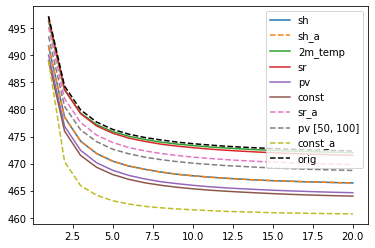

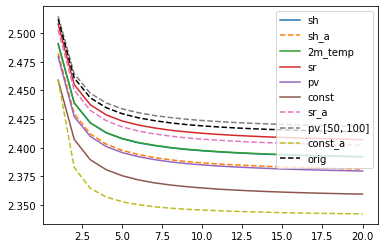

In [26]:
import pylab as plt

plt.plot([i +1 for i in range(len(ens_rmse_list_1))], [ens_rmse_list_1[i].z for i in range(len(ens_rmse_list_1))], label = 'sh')
plt.plot([i +1 for i in range(len(ens_rmse_list_1a))], [ens_rmse_list_1[i].z for i in range(len(ens_rmse_list_1a))], '--',  label = 'sh_a')
plt.plot([i +1 for i in range(len(ens_rmse_list_2))], [ens_rmse_list_2[i].z for i in range(len(ens_rmse_list_2))], label = '2m_temp')
plt.plot([i +1 for i in range(len(ens_rmse_list_3))], [ens_rmse_list_3[i].z for i in range(len(ens_rmse_list_3))], label = 'sr')
plt.plot([i +1 for i in range(len(ens_rmse_list_4))], [ens_rmse_list_4[i].z for i in range(len(ens_rmse_list_4))], label = 'pv')
plt.plot([i +1 for i in range(len(ens_rmse_list_5))], [ens_rmse_list_5[i].z for i in range(len(ens_rmse_list_5))], label = 'const')
plt.plot([i +1 for i in range(len(ens_rmse_list_3a))], [ens_rmse_list_3a[i].z for i in range(len(ens_rmse_list_3a))], '--', label = 'sr_a')
plt.plot([i +1 for i in range(len(ens_rmse_list_4a))], [ens_rmse_list_4a[i].z for i in range(len(ens_rmse_list_4a))], '--', label = 'pv [50, 100]')
plt.plot([i +1 for i in range(len(ens_rmse_list_5a))], [ens_rmse_list_5a[i].z for i in range(len(ens_rmse_list_5a))], '--',  label = 'const_a')
plt.plot([i +1 for i in range(len(ens_rmse_list_6))], [ens_rmse_list_6[i].z for i in range(len(ens_rmse_list_6))], 'k--', label = 'orig')
plt.legend()
plt.show()

plt.plot([i +1 for i in range(len(ens_rmse_list_1))], [ens_rmse_list_1[i].t for i in range(len(ens_rmse_list_1))], label = 'sh')
plt.plot([i +1 for i in range(len(ens_rmse_list_1a))], [ens_rmse_list_1a[i].t for i in range(len(ens_rmse_list_1a))], '--', label = 'sh_a')
plt.plot([i +1 for i in range(len(ens_rmse_list_2))], [ens_rmse_list_2[i].t for i in range(len(ens_rmse_list_2))], label = '2m_temp')
plt.plot([i +1 for i in range(len(ens_rmse_list_3))], [ens_rmse_list_3[i].t for i in range(len(ens_rmse_list_3))], label = 'sr')
plt.plot([i +1 for i in range(len(ens_rmse_list_4))], [ens_rmse_list_4[i].t for i in range(len(ens_rmse_list_4))], label = 'pv')
plt.plot([i +1 for i in range(len(ens_rmse_list_5))], [ens_rmse_list_5[i].t for i in range(len(ens_rmse_list_5))], label = 'const')
plt.plot([i +1 for i in range(len(ens_rmse_list_3a))], [ens_rmse_list_3a[i].t for i in range(len(ens_rmse_list_3a))], '--',  label = 'sr_a')
plt.plot([i +1 for i in range(len(ens_rmse_list_4a))], [ens_rmse_list_4a[i].t for i in range(len(ens_rmse_list_4a))], '--',  label = 'pv [50, 100]')
plt.plot([i +1 for i in range(len(ens_rmse_list_5a))], [ens_rmse_list_5a[i].t for i in range(len(ens_rmse_list_5a))], '--', label = 'const_a')

plt.plot([i +1 for i in range(len(ens_rmse_list_6))], [ens_rmse_list_6[i].t for i in range(len(ens_rmse_list_6))], 'k--', label = 'orig')
plt.legend()
plt.show()

In [41]:
sample_list = [i for i in range(1,200)]
import random
random_list = random.sample(sample_list, 199)

ens_rmse_list = []

ens = preds_sh.isel(ens = 0).copy()

ens_rmse_list.append(compute_weighted_rmse(ens, real_ds).compute())

j = 1

for i in random_list:
    if i < 20:
        ens += preds_sh.sel(ens = i).copy()
    elif i < 40:
        ens += preds_sha.sel(ens = i).copy()        
    elif i < 60:
        ens += preds_2mtemp.sel(ens = i).copy()
    elif i < 80:
        ens += preds_pv.sel(ens = i).copy()
    elif i < 100:
        ens += preds_pva.sel(ens = i).copy()        
    elif i < 120:
        ens += preds_const.sel(ens = i).copy() 
    elif i < 140:
        ens += preds_consta.sel(ens = i).copy()         
    elif i < 160:
        ens += preds_orig.sel(ens = i).copy()
    elif i < 180:
        ens += preds_sr.sel(ens = i).copy()        
    else:
        ens += preds_sra.sel(ens = i).copy()          
    ens_rmse_list.append(compute_weighted_rmse(ens/(j+1), real_ds).compute())
    j +=1   

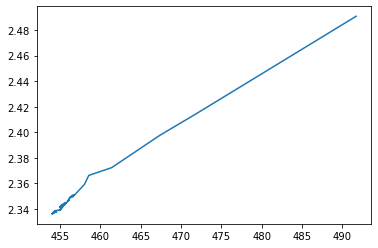

In [42]:
plt.plot([ens_rmse_list[i].z for i in range(len(ens_rmse_list))], [ens_rmse_list[i].t for i in range(len(ens_rmse_list))])


In [43]:
ens_rmse_list[-1]

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 454.0
    t        float64 2.336

In [44]:
# all ensembles

stack_test_list = [ens_1/20, ens_1a/20, ens_2/20, ens_3/20, ens_4/20, ens_5/20, ens_3a/20, ens_5a/20, ens_6/20]

stack_total = sum(stack_test_list)/len(stack_test_list)

compute_weighted_rmse(stack_total, real_ds).compute()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 454.4
    t        float64 2.334

In [45]:
# so orig makes it worse

stack_test_list = [ens_1/20, ens_1a/20, ens_2/20, ens_3/20, ens_4/20, ens_5/20, ens_3a/20, ens_5a/20] #, ens_6/20]

stack_total = sum(stack_test_list)/len(stack_test_list)

compute_weighted_rmse(stack_total, real_ds).compute()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 453.8
    t        float64 2.331

In [46]:
# so orig and solar rad makes it worse

stack_test_list = [ens_1/20, ens_1a/20, ens_2/20, ens_4/20, ens_5/20, ens_5a/20] #, ens_6/20]

stack_total = sum(stack_test_list)/len(stack_test_list)

compute_weighted_rmse(stack_total, real_ds).compute()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 452.9
    t        float64 2.325

In [47]:
# as does 2m temp 

stack_test_list = [ens_1/20, ens_1a/20, ens_4/20, ens_5/20, ens_5a/20] #, ens_6/20]

stack_total = sum(stack_test_list)/len(stack_test_list)

compute_weighted_rmse(stack_total, real_ds).compute()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 451.8
    t        float64 2.323

In [48]:
# as does 2m temp (with different pv)

stack_test_list = [ens_1/20, ens_1a/20, ens_4/20, ens_4a/20, ens_5/20, ens_5a/20] #, ens_6/20]

stack_total = sum(stack_test_list)/len(stack_test_list)

compute_weighted_rmse(stack_total, real_ds).compute()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 451.5
    t        float64 2.327